In [14]:
%%writefile hello_world.py

from mpi4py import MPI

print("Hello World!")

Overwriting hello_world.py


In [15]:
!srun -n 2 -c 2 python hello_world.py

Hello World!
Hello World!


In [16]:
!srun -n 4 -c 4 python hello_world.py

Hello World!
Hello World!
Hello World!
Hello World!


In [17]:
%%writefile hello_world_with_ranks.py
import os
from mpi4py import MPI
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()
name = MPI.Get_processor_name()
pid = os.getpid()
print(f"Hello World! I am process {rank} of {size} on {name} "
       "with pid {pid}.\n") 


Writing hello_world_with_ranks.py


In [19]:
!srun -n 2 -c 2 python hello_world_with_ranks.py

Hello World! I am process 0 of 2 on nid001173 with pid {pid}.

Hello World! I am process 1 of 2 on nid001173 with pid {pid}.



In [20]:
%%writefile send_recv.py

from mpi4py import MPI

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()
if rank == 0:
    data = {'a': 7, 'b': 3.14}
    comm.send(data, dest=1, tag=11)
elif rank == 1:
    data = comm.recv(source=0, tag=11)
    print(data)


Writing send_recv.py


In [23]:
!srun -n 2 -c 2 python send_recv.py

{'a': 7, 'b': 3.14}


In [29]:
%%writefile send_recv_eff.py
import numpy as np
from mpi4py import MPI
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()
if rank == 0:
    data = np.arange(10, dtype='i')
    comm.Send([data, MPI.INT], dest=1, tag=77)
elif rank == 1:
    data = np.empty(10, dtype='i')
    comm.Recv([data, MPI.INT], source=0, tag=77)
    print(data)


Overwriting send_recv_eff.py


In [30]:
!srun -n 2 -c 2 python send_recv_eff.py

[0 1 2 3 4 5 6 7 8 9]


In [31]:
%%writefile send_recv_numpy.py
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

if rank == 0:
    data = np.arange(10, dtype=np.float64)
    comm.Send(data, dest=1, tag=13)
elif rank == 1:
    data = np.empty(10, dtype=np.float64)
    comm.Recv(data, source=0, tag=13)
    print(data)

Writing send_recv_numpy.py


In [32]:
!srun -n 2 -c 2 python send_recv_numpy.py

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


In [37]:
%%writefile barrier.py

from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
for r_id in range(comm.Get_size()):
    if rank == r_id:
        print(f"Hello from proc:")
comm.Barrier()
print(f"proc {rank} after barrier")

Overwriting barrier.py


In [39]:
!srun -n 4 -c 4 python barrier.py

Hello from proc:
proc 0 after barrier
Hello from proc:
proc 1 after barrier
Hello from proc:
proc 2 after barrier
Hello from proc:
proc 3 after barrier


In [40]:
%%writefile scatter.py
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

if rank == 0:
    data = [(i+1)**2 for i in range(size)]
else:
    data = None

data = comm.scatter(data, root=0)
assert data == (rank+1)**2

print(f"data on rank %d is: {rank}, {data}")

Writing scatter.py


In [41]:
!srun -n 4 -c 4 python scatter.py

data on rank %d is: 0, 1
data on rank %d is: 2, 9
data on rank %d is: 1, 4
data on rank %d is: 3, 16


In [44]:
%%writefile gather.py
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

data = (rank+1)**2
print(f"before gather, data on rank %d is: {rank}, {data}")

comm.Barrier()
data = comm.gather(data, root=0)
if rank == 0:
    for i in range(size):
        assert data[i] == (i+1)**2
else:
    assert data is None

print(f"data on rank: {rank} is: {data}")


Overwriting gather.py


In [45]:
!srun -n 4 -c 4 python gather.py

before gather, data on rank %d is: 1, 4
data on rank: 1 is: None
before gather, data on rank %d is: 2, 9
data on rank: 2 is: None
before gather, data on rank %d is: 3, 16
data on rank: 3 is: None
before gather, data on rank %d is: 0, 1
data on rank: 0 is: [1, 4, 9, 16]


In [46]:
%%writefile reduce.py
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

sendmsg = rank
recvmsg1 = comm.reduce(sendmsg, op=MPI.SUM, root=0)
recvmsg2 = comm.allreduce(sendmsg)

print(recvmsg2)


Writing reduce.py


In [49]:
!srun -n 4 -c 4 python reduce.py

6
6
6
6


## Compute Pi Example

The following example is completely self-contained to simplify reuse in another script.  You can switch between running the code in parallel and serial by executing an %autopx cell.

In [50]:
%%writefile compute_pi.py
from mpi4py import MPI
import math

def compute_pi(n, start=0, step=1):
    h = 1.0 / n
    s = 0.0
    for i in range(start, n, step):
        x = h * (i + 0.5)
        s += 4.0 / (1.0 + x**2)
    return s * h

comm = MPI.COMM_WORLD
nprocs = comm.Get_size()
myrank = comm.Get_rank()
if myrank == 0:
    n = 10
else:
    n = None

n = comm.bcast(n, root=0)

mypi = compute_pi(n, myrank, nprocs)

pi = comm.reduce(mypi, op=MPI.SUM, root=0)

if myrank == 0:
    error = abs(pi - math.pi)
    print("pi is approximately %.16f\nerror is %.16f" % (pi, error))

Writing compute_pi.py


In [51]:
!srun -n 4 -c 4 python compute_pi.py

pi is approximately 3.1424259850010983
error is 0.0008333314113051


## Mandelbrot Set Example

The following example is completely self-contained to simplify reuse in another script.

In [69]:
%%writefile compute_mandelbot.py
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from mpi4py import MPI
import numpy as np

def mandelbrot (x, y, maxit):
    c = x + y*1j
    z = 0 + 0j
    it = 0
    while abs(z) < 2 and it < maxit:
        z = z**2 + c
        it += 1
    return it

x1, x2 = -2.0, 1.0
y1, y2 = -1.0, 1.0
w, h = 250, 200
maxit = 127
  
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

# number of rows to compute here
N = h // size + (h % size > rank)

# first row to compute here
start = comm.scan(N)-N

# array to store local result
Cl = np.zeros([N, w], dtype='i')

# compute owned rows

dx = (x2 - x1) / w
dy = (y2 - y1) / h

for i in range(N):
    y = y1 + (i + start) * dy
    for j in range(w):
        x = x1 + j * dx
        Cl[i, j] = mandelbrot(x, y, maxit)

# gather results at root (process 0)
counts = comm.gather(N, root=0)
C = None
if rank == 0:
    C = np.zeros([h, w], dtype='i')

# here we create a custom datatype for sending/receiving rows of data.
rowtype = MPI.INT.Create_contiguous(w)
rowtype.Commit()

comm.Gatherv(sendbuf=[Cl, MPI.INT], recvbuf=[C, (counts, None), rowtype],root=0)

rowtype.Free()

if rank==0:
    # Do the plotting on rank 0
    plt.figure()
    plt.imshow(C, cmap=cm.Spectral)
    plt.savefig('test.png')

Overwriting compute_mandelbot.py


In [70]:
!srun -n 4 -c 4 python compute_mandelbot.py

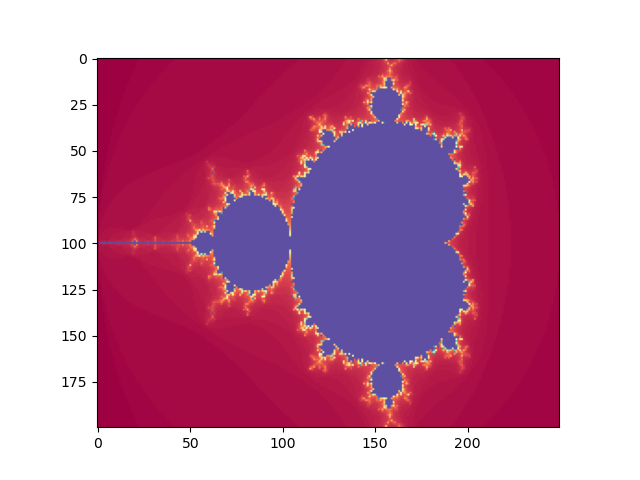

In [71]:
from IPython.display import Image
Image(filename='test.png') 